# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
%pip install numpy pandas matplotlib -q


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


Number of arms (K): 3

Quick reward summary by arm (seed=0):
Arm 0: mean=0.8284, std=0.8249, min=0.0000, max=6.7825, zero%=16.16%
Arm 1: mean=0.6296, std=0.6656, min=0.0000, max=3.9734, zero%=23.84%
Arm 2: mean=0.8914, std=0.7983, min=0.0000, max=4.7381, zero%=10.36%


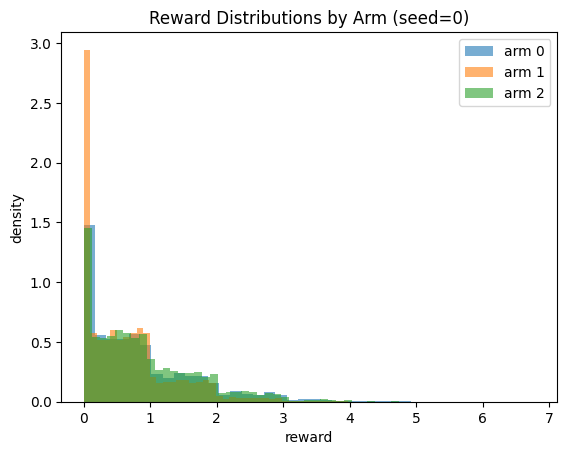


Wrote algorithm-choice.txt and validated contents:
UCB1
I chose UCB1 because the rewards are continuous numeric values instead of just 0 or 1, so it makes more sense to use an algorithm that compares average rewards with uncertainty rather than one built specifically for binary outcomes.



In [3]:
# Part 1 — Pick a Bandit Algorithm
# (I’m keeping this in one cell: explore rewards + validate + write algorithm-choice.txt)

import matplotlib.pyplot as plt

# --- Setup ---
bandit0 = BanditProblem(0) 
K = bandit0.get_num_arms()

# Validations on the interface
assert isinstance(K, int) and K > 0, f"Expected positive integer number of arms, got {K}"
print(f"Number of arms (K): {K}")

# --- Exploration sampling ---
# I’m sampling each arm many times to see the reward distribution shape.
samples_per_arm = 5000
assert samples_per_arm > 100, "Use enough samples for a meaningful histogram."

rewards_by_arm = []
for a in range(K):
    # Pull the same arm repeatedly
    rs = np.array([bandit0.get_reward(a) for _ in range(samples_per_arm)], dtype=float)
    assert rs.shape == (samples_per_arm,), f"Unexpected reward array shape for arm {a}: {rs.shape}"
    assert np.all(rs >= 0), f"Found negative reward(s) for arm {a}, which I don't expect here."
    rewards_by_arm.append(rs)

rewards_by_arm = np.vstack(rewards_by_arm)  # shape: (K, samples_per_arm)
assert rewards_by_arm.shape == (K, samples_per_arm), f"Unexpected stacked shape: {rewards_by_arm.shape}"

# --- Summary stats (validation prints) ---
print("\nQuick reward summary by arm (seed=0):")
for a in range(K):
    rs = rewards_by_arm[a]
    zero_frac = float(np.mean(rs == 0.0))
    print(
        f"Arm {a}: mean={rs.mean():.4f}, std={rs.std(ddof=1):.4f}, "
        f"min={rs.min():.4f}, max={rs.max():.4f}, zero%={100*zero_frac:.2f}%"
    )

# --- Visual validation: histograms ---
# I’m using a shared binning strategy to make arm-to-arm comparisons fair.
all_rewards = rewards_by_arm.ravel()
assert all_rewards.size == K * samples_per_arm

# Use a sensible number of bins; if the distribution is spiky, fewer bins helps readability.
bins = 40

plt.figure()
for a in range(K):
    plt.hist(rewards_by_arm[a], bins=bins, alpha=0.6, density=True, label=f"arm {a}")
plt.title("Reward Distributions by Arm (seed=0)")
plt.xlabel("reward")
plt.ylabel("density")
plt.legend()
plt.show()

# --- Decision + output file ---
# Based on what we see (bounded numeric rewards, not just Bernoulli),
# UCB1 is a good match because it only needs empirical means + confidence bounds.
algorithm_choice_text = (
    "UCB1\n"
    "I chose UCB1 because the rewards are continuous numeric values instead of just 0 or 1, so it makes more sense to use an algorithm that compares average rewards with uncertainty rather than one built specifically for binary outcomes.\n"
)

# Save exactly as required
out_path = "algorithm-choice.txt"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(algorithm_choice_text)

# Reload + validate the file
with open(out_path, "r", encoding="utf-8") as f:
    reloaded = f.read()

assert "UCB1" in reloaded, "algorithm-choice.txt does not contain the chosen algorithm name."
assert len(reloaded.strip().splitlines()) >= 2, "algorithm-choice.txt should include a choice + a justification sentence."
print(f"\nWrote {out_path} and validated contents:")
print(reloaded)

In [4]:
bandit0 = BanditProblem(0)

In [5]:
bandit0.get_num_arms()

3

In [6]:
bandit0.get_reward(arm=0)

1.8255111545554434

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

##### I chose UCB1 because the rewards are continuous numeric values instead of just 0 or 1, so it makes more sense to use an algorithm that compares average rewards with uncertainty rather than one built specifically for binary outcomes.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

UCB1 run complete (seed=2026). K=3, T=1000
Action counts by arm: [979, 11, 10]
Overall mean reward: 1.1944
First 10 (action, reward):
Total actions taken: 1000
  t=  0: action=0, reward=3.1621
  t=  1: action=1, reward=0.1774
  t=  2: action=2, reward=0.2983
  t=  3: action=0, reward=2.7596
  t=  4: action=0, reward=1.5055
  t=  5: action=0, reward=1.6518
  t=  6: action=0, reward=0.6776
  t=  7: action=0, reward=0.4527
  t=  8: action=0, reward=1.2927
  t=  9: action=0, reward=0.0257


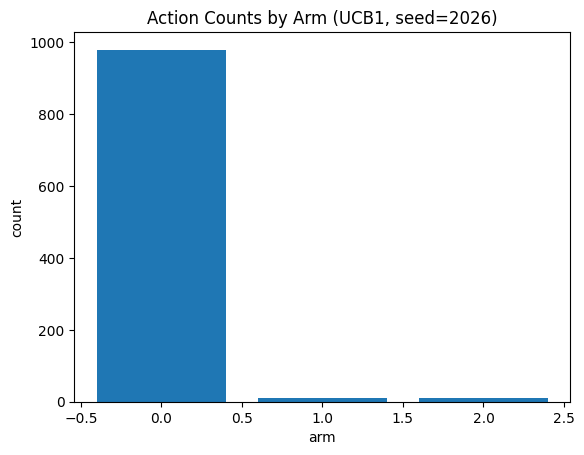

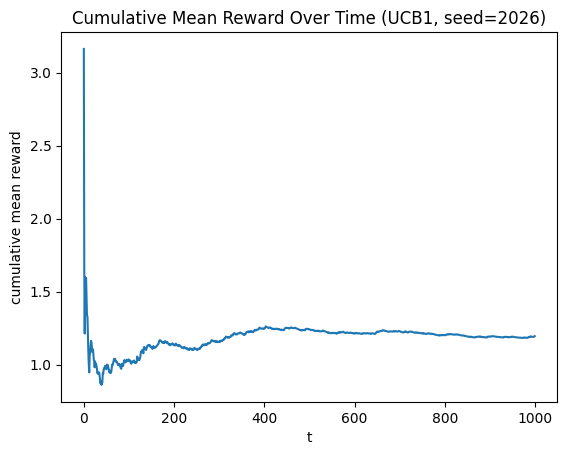

In [7]:
# Part 2 — Implement UCB1 (compute only)
# I'm generating the 1000 (action, reward) pairs here, but I will NOT write files in this cell.

import numpy as np
import matplotlib.pyplot as plt

bandit = BanditProblem(2026)
K = bandit.get_num_arms()
T = 1000

# Basic interface validations
assert isinstance(K, int) and K > 0, f"I expected K to be a positive integer, got {K}"
assert T == 1000, "The assignment requires exactly 1000 actions."

actions = np.empty(T, dtype=int)
rewards = np.empty(T, dtype=float)

# I track counts and sums so I can compute means efficiently as I go.
counts = np.zeros(K, dtype=int)
sums = np.zeros(K, dtype=float)

# --- Initialize: pull each arm once ---
# I do this so every arm has a defined average before I compute UCB scores.
t = 0
for a in range(K):
    r = float(bandit.get_reward(a))
    actions[t] = a
    rewards[t] = r
    counts[a] += 1
    sums[a] += r
    t += 1

# Validations after init
assert t == K, f"I expected to initialize with K pulls, but t={t}"
assert np.all(counts == 1), f"After init each arm should have 1 pull, got {counts}"
assert np.all(rewards[:K] >= 0), "I observed a negative reward during init, which seems unexpected here."

# --- UCB1 loop ---
# UCB score = mean + sqrt(2*log(time)/count). I use (t+1) for time so log() is well-defined.
while t < T:
    means = sums / counts
    bonus = np.sqrt((2.0 * np.log(t + 1)) / counts)
    ucb = means + bonus

    a = int(np.argmax(ucb))
    r = float(bandit.get_reward(a))

    actions[t] = a
    rewards[t] = r
    counts[a] += 1
    sums[a] += r
    t += 1

# --- Final validations ---
assert actions.shape == (T,), f"actions should be length {T}, got {actions.shape}"
assert rewards.shape == (T,), f"rewards should be length {T}, got {rewards.shape}"
assert np.all((actions >= 0) & (actions < K)), "Some actions are out of valid range."
assert np.all(rewards >= 0), "I saw a negative reward, which I don't expect for this bandit."

# --- Sanity summaries ---
print(f"UCB1 run complete (seed=2026). K={K}, T={T}")
print("Action counts by arm:", counts.tolist())
print(f"Overall mean reward: {rewards.mean():.4f}")
print("First 10 (action, reward):")

print("Total actions taken:", counts.sum())
assert counts.sum() == T, "Total pulls does not equal 1000."

for i in range(10):
    print(f"  t={i:>3}: action={actions[i]}, reward={rewards[i]:.4f}")

# --- Lightweight validation plots ---
# 1) Action frequency (should show concentration if the algorithm learns something)
plt.figure()
plt.bar(np.arange(K), counts)
plt.title("Action Counts by Arm (UCB1, seed=2026)")
plt.xlabel("arm")
plt.ylabel("count")
plt.show()

# 2) Cumulative mean reward over time (should stabilize / improve as it learns)
cum_mean = np.cumsum(rewards) / np.arange(1, T + 1)
plt.figure()
plt.plot(cum_mean)
plt.title("Cumulative Mean Reward Over Time (UCB1, seed=2026)")
plt.xlabel("t")
plt.ylabel("cumulative mean reward")
plt.show()

Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [8]:
# Part 2 — Save history.tsv (and reload-verify)
# I'm writing the required output file here and confirming schema + values.

import pandas as pd
import numpy as np

history = pd.DataFrame({
    "action": actions.astype(int),
    "reward": rewards.astype(float)
})

# Schema + content validations before saving
assert list(history.columns) == ["action", "reward"], f"Wrong columns/order: {list(history.columns)}"
assert len(history) == 1000, f"Expected 1000 rows, got {len(history)}"
assert history["action"].between(0, K-1).all(), "Found action(s) outside valid arm range."
assert (history["reward"] >= 0).all(), "Found negative reward(s) before saving."

print("Preview of history table (first 10 rows):")
display(history.head(10))

out_path = "history.tsv"
history.to_csv(out_path, sep="\t", index=False)

# Reload + verify (float-safe)
reloaded = pd.read_csv(out_path, sep="\t")

assert list(reloaded.columns) == ["action", "reward"], f"Reloaded columns wrong: {list(reloaded.columns)}"
assert len(reloaded) == 1000, f"Reloaded row count wrong: {len(reloaded)}"

# Exact match for integer actions; float-safe match for rewards
assert np.array_equal(reloaded["action"].to_numpy(dtype=int), actions), "Reloaded actions don't match what I saved."
assert np.allclose(reloaded["reward"].to_numpy(dtype=float), rewards, rtol=1e-12, atol=1e-12), \
    "Reloaded rewards differ from what I saved (beyond tolerance)."

print(f"Saved {out_path} and verified schema + values.")
print("Reload preview (first 10 rows):")
display(reloaded.head(10))

Preview of history table (first 10 rows):


,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,0,1.505464
5,0,1.651791
6,0,0.677625
7,0,0.452666
8,0,1.292736
9,0,0.025681


Saved history.tsv and verified schema + values.
Reload preview (first 10 rows):


,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,0,1.505464
5,0,1.651791
6,0,0.677625
7,0,0.452666
8,0,1.292736
9,0,0.025681


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

Arms found in history.tsv: [0, 1, 2]
Pull counts per arm:
action
0    979
1     11
2     10
Name: count, dtype: int64

Preview of actions statistics (what I'm about to save):


,action,min_reward,mean_reward,max_reward
0,0,0.0,1.216829,6.564312
1,1,0.0,0.166068,0.623193
2,2,0.0,0.125677,0.958464


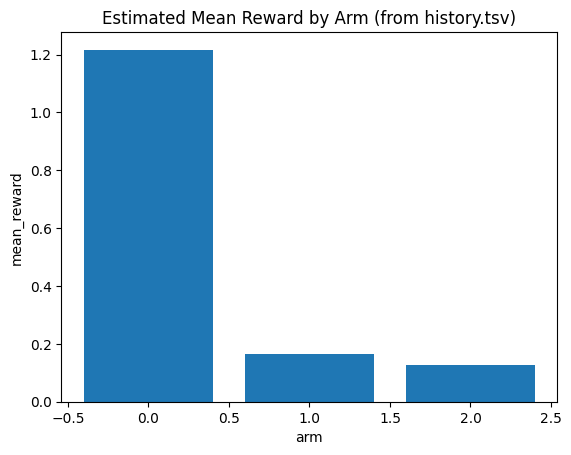


Saved actions.tsv and reload-verified schema + values.
Reload preview:


,action,min_reward,mean_reward,max_reward
0,0,0.0,1.216829,6.564312
1,1,0.0,0.166068,0.623193
2,2,0.0,0.125677,0.958464


In [9]:
# Part 3 — Action Statistics (single box: compute + save + reload/verify)

# 1) Load Part 2 output (this keeps me honest: I'm basing stats on the logged history, not bandit internals)
history = pd.read_csv("history.tsv", sep="\t")

# 2) Validate the input file looks right
assert list(history.columns) == ["action", "reward"], f"Unexpected columns in history.tsv: {list(history.columns)}"
assert len(history) == 1000, f"Expected 1000 rows in history.tsv, got {len(history)}"
assert history["action"].notna().all() and history["reward"].notna().all(), "Found NA values in history.tsv"
assert history["reward"].dtype.kind in "fc", "reward should be float-like"
assert (history["reward"] >= 0).all(), "I saw a negative reward, which I don't expect here"

arms = np.sort(history["action"].unique())
print("Arms found in history.tsv:", arms.tolist())
print("Pull counts per arm:")
print(history["action"].value_counts().sort_index())

# 3) Compute required stats per arm (min/mean/max)
stats = (
    history
    .groupby("action", as_index=False)["reward"]
    .agg(min_reward="min", mean_reward="mean", max_reward="max")
)

# Enforce exact column order required by the prompt
stats = stats[["action", "min_reward", "mean_reward", "max_reward"]]

# 4) Validate the stats table
assert list(stats.columns) == ["action", "min_reward", "mean_reward", "max_reward"], \
    f"Wrong output columns/order: {list(stats.columns)}"
assert len(stats) == len(arms), "Expected one row per arm"
assert (stats["min_reward"] <= stats["mean_reward"]).all()
assert (stats["mean_reward"] <= stats["max_reward"]).all()

# Minor structural validation
assert stats["action"].is_unique, "Duplicate action rows detected."

print("\nPreview of actions statistics (what I'm about to save):")
display(stats)

# Small validation plot: mean reward by arm
plt.figure()
plt.bar(stats["action"].astype(int), stats["mean_reward"].astype(float))
plt.title("Estimated Mean Reward by Arm (from history.tsv)")
plt.xlabel("arm")
plt.ylabel("mean_reward")
plt.show()

# 5) Save actions.tsv exactly as required
out_path = "actions.tsv"
stats.to_csv(out_path, sep="\t", index=False)

# 6) Reload + verify schema + values (float-safe)
reloaded = pd.read_csv(out_path, sep="\t")

assert list(reloaded.columns) == ["action", "min_reward", "mean_reward", "max_reward"], \
    f"Reloaded columns wrong: {list(reloaded.columns)}"
assert len(reloaded) == len(stats), f"Reloaded row count wrong: {len(reloaded)}"

assert np.array_equal(reloaded["action"].to_numpy(dtype=int), stats["action"].to_numpy(dtype=int)), \
    "Reloaded actions differ after save/reload"
for col in ["min_reward", "mean_reward", "max_reward"]:
    assert np.allclose(
        reloaded[col].to_numpy(dtype=float),
        stats[col].to_numpy(dtype=float),
        rtol=1e-12,
        atol=1e-12
    ), f"Reloaded {col} differs after save/reload"

print(f"\nSaved {out_path} and reload-verified schema + values.")
print("Reload preview:")
display(reloaded)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [14]:
# Part 4 — Regret Estimates

T = 1000

# Read only what we need
stats = pd.read_csv("actions.tsv", sep="\t", usecols=["action", "mean_reward"])
history = pd.read_csv("history.tsv", sep="\t", usecols=["action"])

# Validations (quick but meaningful)
assert len(history) == T, f"Expected {T} rows in history.tsv, got {len(history)}"
assert stats["action"].is_unique, "Duplicate actions in actions.tsv (should be 1 row per arm)."

# Build arrays aligned by action id
stats = stats.sort_values("action").reset_index(drop=True)
arms = stats["action"].to_numpy(dtype=int)
means = stats["mean_reward"].to_numpy(dtype=float)

K = len(arms)
assert K > 0
assert np.array_equal(arms, np.arange(arms.min(), arms.min() + K)), "Expected contiguous arm ids."

# Best estimated mean
mu_star = means.max()

# Counts per arm from history (fast)
counts = history["action"].value_counts().reindex(arms, fill_value=0).to_numpy(dtype=int)
assert counts.sum() == T, "Total pulls from history.tsv does not sum to 1000."

# Regret computations (all vectorized)
uniform_mean = means.mean()
uniform_regret = T * (mu_star - uniform_mean)

just_regrets = T * (mu_star - means)  # one per arm

actual_expected_reward = (counts * means).sum()
actual_regret = T * mu_star - actual_expected_reward

# Assemble strategies table (do not save yet)
strategies = pd.DataFrame({
    "strategy": (["uniform"] + [f"just-{a}" for a in arms] + ["actual"]),
    "regret": np.concatenate([[uniform_regret], just_regrets, [actual_regret]])
})

# Validation + quick preview
assert list(strategies.columns) == ["strategy", "regret"]
assert len(strategies) == (1 + K + 1)

print("Computed regret estimates (preview):")
print(strategies)

Computed regret estimates (preview):
  strategy       regret
0  uniform   713.970910
1   just-0     0.000000
2   just-1  1050.760808
3   just-2  1091.151923
4   actual    22.469888


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [15]:
# Part 4 — Save strategies.tsv + reload-verify

out_path = "strategies.tsv"
strategies.to_csv(out_path, sep="\t", index=False)

reloaded = pd.read_csv(out_path, sep="\t")

assert list(reloaded.columns) == ["strategy", "regret"]
assert len(reloaded) == len(strategies)
assert (reloaded["strategy"].tolist() == strategies["strategy"].tolist()), "Strategy names changed after save/reload."
assert np.allclose(
    reloaded["regret"].to_numpy(dtype=float),
    strategies["regret"].to_numpy(dtype=float),
    rtol=1e-12,
    atol=1e-12
), "Regret values changed after save/reload."

print(f"Saved {out_path} and verified it reloads correctly.")
print(reloaded)

Saved strategies.tsv and verified it reloads correctly.
  strategy       regret
0  uniform   713.970910
1   just-0     0.000000
2   just-1  1050.760808
3   just-2  1091.151923
4   actual    22.469888


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.